In [10]:
### Import Functions
from DirectFunctions import import_fx_data, plot_forex, direct_daily_rets, compute_hedge_ratio, calculate_hedged_unhedged, plot_hedged_returns, performance_metrics


In [11]:
### Call Function to Load in Rate Data
forex_pairs = ['USDJPY=X', 'CADCHF=X']
start_date = '2021-01-01'
forex_data = import_fx_data(forex_pairs, start_date)
forex_data.tail()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,USDJPY=X,CADCHF=X
898,2024-06-12,157.104996,0.65264
899,2024-06-13,156.800003,0.65166
900,2024-06-14,157.128006,0.65041
901,2024-06-17,157.546005,0.64846
902,2024-06-18,157.656006,NaN


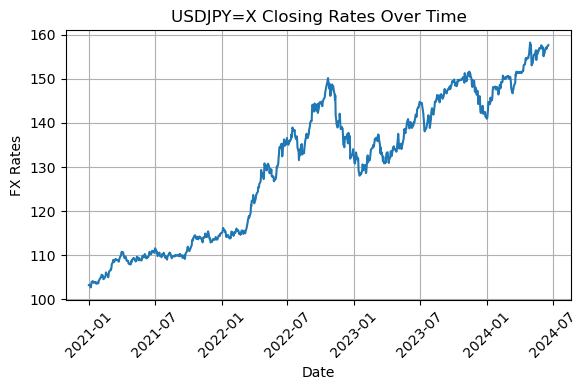

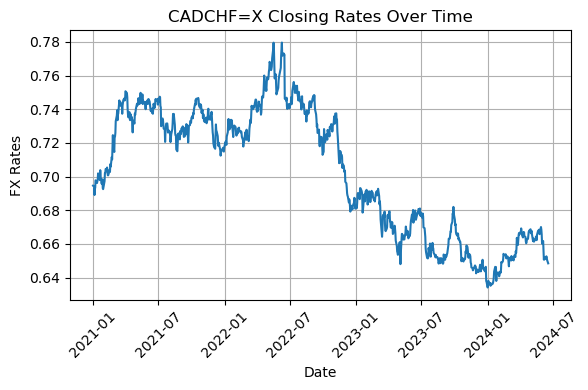

In [12]:
### Plot FX Pairs
plot_forex(forex_data, forex_pairs)


In [13]:
### Call Function to Calculate Daily Returns
daily_returns = direct_daily_rets(forex_data)
print(daily_returns.head())


        Date  USDJPY=X  CADCHF=X
0 2021-01-04  0.000126 -0.000806
1 2021-01-05 -0.001104 -0.007190
2 2021-01-06 -0.004335  0.005428
3 2021-01-07  0.003370  0.000707
4 2021-01-08  0.007435  0.006491


In [14]:
### Call Hedge Ratio Function
hedge_ratio = compute_hedge_ratio(forex_pairs, daily_returns)
print("Hedge Ratio:", hedge_ratio)


Hedge Ratio: 0.23085683556401365


In [15]:
### Function Call to return Hedged and Unhedged Cumulative Returns
# Set value of Long Position
long_pos = 1000  
short_pos, hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(long_pos, forex_pairs, daily_returns, hedge_ratio)
print("Long Position Size: ", long_pos)
print("Short Position Size: ", round(short_pos, 4))
print("Recent Hedged Cumulative Returns: ", hedged_cumulative_rets.tail(5))
print("Recent Unhedged Cumulative Returns: ", unhedged_cumulative_rets.tail(5))


Long Position Size:  1000
Short Position Size:  -230.8568
Recent Hedged Cumulative Returns:  897    1542.300456
898    1539.840963
899    1543.743983
900    1548.919214
901    1550.000689
dtype: float64
Recent Unhedged Cumulative Returns:  897    1521.951823
898    1518.997212
899    1522.174734
900    1526.224095
901    1527.289724
Name: USDJPY=X, dtype: float64


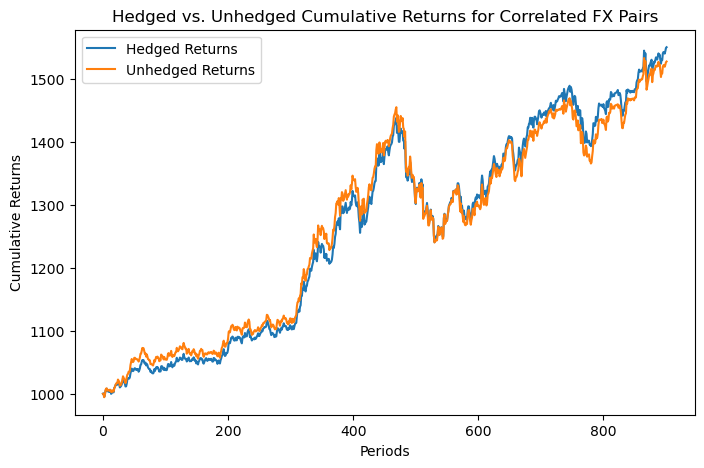

In [16]:
### Plot Hedged vs. Unhedged Returns
plot_hedged_returns(hedged_cumulative_rets, unhedged_cumulative_rets)


In [17]:
### Performance Metrics Function Return
performance_metrics(long_pos, hedged_cumulative_rets, unhedged_cumulative_rets, daily_returns)


Metric                                  Hedged        Unhedged
Total Returns                         550.0007        527.2897
Annualized Returns                      4.8320          4.7639
Mean Return                          1262.5123       1264.7028
Standard Deviation                    166.9842        156.6977
Sharpe Ratio                          120.0219        128.1227

The Sharpe ratio measures the risk-adjusted return of an investment.
In this instance, the hedged strategy has a Sharpe ratio of 120.0219,
which means for every unit of risk, the hedged portfolio is generating 120.0219 units of return above the risk-free rate.
The unhedged strategy has a Sharpe ratio of 128.1227,
indicating that for every unit of risk, the unhedged portfolio is generating 128.1227 units of return above the risk-free rate.
A higher Sharpe ratio typically indicates a more favorable risk-adjusted return.
